In [3]:
%pylab inline
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from writeit import *


Populating the interactive namespace from numpy and matplotlib


In [4]:
import time
np.random.seed(555)
Nsamples =100
Summary = []

N = 20

fn = '../indata/randomwithN%d'%N
m32gal = 264.172


#generator = 'wilson' #sample complete graph to get an admissible tree
generator = 'spine'  #start with N-2 pipes comprising 'spine'; pick S random nodes between 1 and N1-1 to add spurs

    
for m in range(Nsamples):
    print "sample # %d\n"%m
    if generator=='wilson':
        print "generating random trees using Wilson's algorithm on complete graph, followed by filter for degree <3"
        Np = N-1
        Nn = N
        Ds = [0.1]*Np
        A2 = np.ones((N,N))-np.diag(np.ones(N),0)
        Gl2  = listRep(A2)
        nodeTypes = [4]*N
        while max(nodeTypes)>3 or nodeTypes[0]!=1:
            conn2 = randomTreeWithRoot(0,Gl2)
            nl = conn2[:,0]
            nr = conn2[:,1]
            nodeTypes = [sum(len(find(nl==k))+len(find(nr==k))) for k in range(N)]
        IN = nodeTypes.index(1)
    
    if generator =='spine':
        S = 5
        N1 = N-N/4
        N2 = S
        Np = N1+N2-1
        Nn = N1+N2
        print "generating random trees starting with spine of %d nodes and adding %d branches"%(N1,N2)
        conn2 = np.ndarray((N1+N2-1,2),int)
        for k in range(N1-1):
            conn2[k,:] = (k,k+1)
            avail = [i for i in range(1,N1-1)]
        for k in range(N2):
            where = np.random.randint(0,N1-2-k)
            spur = avail.pop(where)
            conn2[k+N1-1,0]=spur
            conn2[k+N1-1,1] = N1+k
        nl = conn2[:,0]
        nr = conn2[:,1]
        nodeTypes = [sum(len(find(nl==k))+len(find(nr==k))) for k in range(Nn)]
        IN =0
        Ds = [0.1]*(N1-1)+[.1]*N2

    Ls = [20]*Np
    print Ls
    Ns = [int(max(Ls))]*Np
    #Ns = [int(Ls[j]) for j in range(Np)]
    Mrs = [0.007]*Np
    print Mrs[0]
    h0s = [0.000]*Np
    q0s = [0.00]*Np
    T = 10.
    Mi = 10
    Nt = 2*N+3
    Tmax = Nt*T

    a = np.random.normal(150,50)
    dx = [Ls[i]/Ns[i] for i in range(Np)] 

    tol = Ds[0]
    print nodeTypes
    fn = '../indata/randomwithN%d'%N
    jt = nodeTypes
    
    xs = np.random.rand(Nn)
    ys = np.random.rand(Nn)
    #reflect everything
    bt = [1]*Nn
    r = [1]*Nn
    r[IN]=0
    bv = [0.]*Nn
    bv[IN]=0.0087
    elevs = [0]*Nn
    elevs[IN] +=.1*Ls[0]
    #elevs = [e+np.random.normal(0,elevs[0]/8.) for e in elevs]
    print elevs
    print a
    M = int(T*a/(max(dx)*.8))


    (fi, fc) = writePipes(fn,conn2, xs,ys, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
    arrive = np.zeros((Np,Ns[0]))
    maxH = np.zeros(Np)
    Vsys = np.pi*Ds[0]**2/4.*sum(Ls)
    print "system volume is %f gal "%(Vsys*m32gal)
    Hs =np.zeros((M/Mi*Nt,sum(Ns)))
    n0=PyNetwork(fi,fc,1)
    
    print n0.Ns

    dt = T/float(M)
    #Q0 = 0.0087*np.ones(M+1)
    #n0.setbVal(0,Q0)
    V0 = n0.getTotalVolume()
    Vin =  0
    Ttot = 0
    count = 0
    t0 = time.clock()
    dH = []
    while count<Nt and Vin<Vsys:
        n0.runForwardProblem(dt)
        Vin  = n0.getTotalVolume()-V0
        for k in range(0,Np):
            for K in range(0,Ns[k]):
                Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
                #Hs[count*M/Mi:(count+1)*(M/Mi),K+Ns[0]*k] =Ht[1::Mi] 
                maxH[k] = max(max(Ht),maxH[k])
                where = find(Ht>tol)
                if len(where)>0 and arrive[k,K]==0.:
                    arrive[k,K] = Ttot+dt*(where[0])
        dH.append(mean([n0.getAveGradH(i) for i in range(M+1)]))
        count+=1
        Ttot +=T
        print "T = %f, Volume = %f"%(Ttot, m32gal*Vin)
        n0.reset()
    tf = time.clock()
    print "inflow volume is %f gallons"%(Vin*m32gal)
    print "simulation time is %f s"%Ttot
    print "wall clock time is %f s"%(tf-t0)
    print dH
    print maxH
    print "max arrival time is %f"%(arrive.max())
    data = {}
    data['conn']=conn2
    data['a'] = a
    data['max_arrive_t'] = [max(arrive[k,:]) for k in range(Np)]
    data['min_arrive_t'] = [min(arrive[k,:]) for k in range(Np)]
    data['last_arrive_t'] = arrive.max()
    data['nodeTypes'] = nodeTypes
    data['mean_dH'] = mean(dH)
    data['max_H'] = maxH
    data['Vin'] = Vin

    Summary.append(data)
    

    
    

sample # 0

generating random trees starting with spine of 15 nodes and adding 5 branches
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
0.007
[1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]
[2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
198.871309451
../indata/fakeinp.inp
system volume is 788.424774 gal 
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
T = 10.000000, Volume = 37.986761
T = 20.000000, Volume = 75.702589
T = 30.000000, Volume = 113.418418
T = 40.000000, Volume = 151.134246
T = 50.000000, Volume = 181.632891
T = 60.000000, Volume = 204.615880
T = 70.000000, Volume = 227.598875
T = 80.000000, Volume = 250.581870
T = 90.000000, Volume = 273.564866
T = 100.000000, Volume = 296.547862
T = 110.000000, Volume = 319.530858
T = 120.000000, Volume = 342.513854
T = 130.000000, Volume = 365.496850
T = 140.000000, Volume = 388.479865
T = 150.000000, Volume = 411.462901
T = 160.000000, Volume = 434.445941
T = 170.00

In [5]:

print "max(T_a)  mean(max(H))  mean(dH)   a"
for k in range(len(Summary)):
    print"%3.2f    %2.6f     %3.6f   %.2f   "%(Summary[k]['last_arrive_t'],\
                                         mean(Summary[k]['max_H']),Summary[k]['mean_dH'],Summary[k]['a'])

max(T_a)  mean(max(H))  mean(dH)   a
317.33    69.286131     10.645587   198.87   
299.22    40.892923     19.186011   146.51   
309.61    31.562048     9.434894   187.91   
328.22    16.583420     3.866504   76.74   
317.21    29.383838     5.594357   127.24   
292.67    20.191568     6.685266   145.27   
326.88    15.507708     3.927888   73.72   
318.02    43.421884     10.330287   208.28   
293.83    16.912818     4.971174   120.27   
307.33    38.178464     9.343846   187.00   
315.49    87.719792     11.843313   224.39   
302.30    134.974682     12.140594   219.65   
291.99    26.631282     10.284195   207.70   
309.61    22.815363     7.203351   151.28   
318.13    35.541200     5.814535   140.39   
275.09    17.439249     5.673632   124.84   
318.65    24.229696     5.528470   124.65   
318.01    33.983803     6.818655   137.07   
304.62    64.949796     8.433802   150.76   
317.71    39.441894     10.690326   223.76   
279.55    14.241251     3.784583   88.71   
299.65    19.

5


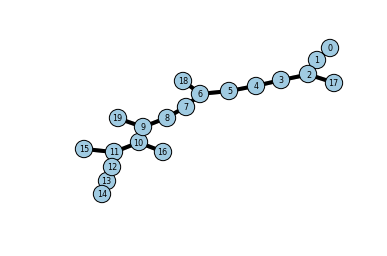

In [6]:
which = 0
conns = Summary[which]['conn']
import networkx as nx
from networkx import graphviz_layout
G=nx.Graph()
Dpos = {}
for k in range(len(Summary[which]['nodeTypes'])-1):
    G.add_edge('%d'%conns[k,0],'%d'%conns[k,1])
pos=nx.spring_layout(G) # positions for all nodes
pos=nx.graphviz_layout(G,root=0)
# nodes
nx.draw_networkx_nodes(G,pos,node_size=300,node_color = '#A0CBE2', iter=100)
# edges
nx.draw_networkx_edges(G,pos,width=4,edge_cmap=plt.cm.coolwarm)
nx.draw_networkx_edges(G,pos,width=4.0,alpha=0.3)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
print Summary[0]['nodeTypes'].count(3)


In [7]:
import pickle

In [8]:
#generator = 'wilson'
name = "output_data/random_networks/summary_N%d_samples%d_%s_random_wavespeed"%(N,Nsamples,generator)
#name = "output_data/random_networks/summary_N%d_samples%d_%s"%(N,Nsamples,generator)
f1 = open(name+'.pkl','wb')
pickle.dump(Summary,f1)
f1.close()

In [9]:
with open(name+'.txt','w') as f2:
    f2.write("max(T_a)  mean(max(H))  mean(dH)   %junction1s %junction2s   %junction3s\n")
    for k in range(len(Summary)):
        c = [Summary[k]['nodeTypes'].count(j) for j in range(1,4)]
        f2.write("%3.2f    %2.6f     %3.6f   %.2f          %.2f               %.2f\n"%(Summary[k]['last_arrive_t'],\
                                         mean(Summary[k]['max_H']),Summary[k]['mean_dH'],c[0]/float(N), c[1]/float(N),c[2]/float(N)))

In [10]:
name = "output_data/random_networks/summary_N%d_samples%d_%s_variable_spurs"%(N,Nsamples,generator)
print name

output_data/random_networks/summary_N20_samples100_spine_variable_spurs


[1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 1, 3, 2, 1, 3, 1]


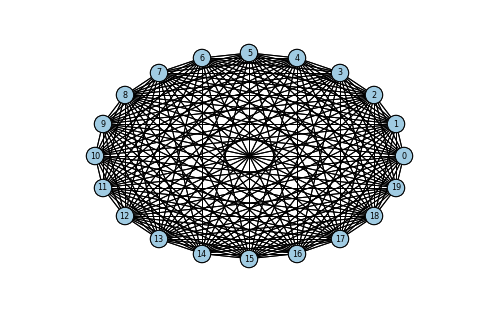

In [146]:
G = nx.Graph(A2)
#pos=nx.spectral_layout(G) # positions for all nodes
# nodes
nx.draw_circular(G,node_size=300,node_color = '#A0CBE2')
pos=nx.circular_layout(G) # positions for all nodes
# nodes
nx.draw_networkx_nodes(G,pos,node_size=300,node_color = '#A0CBE2', iter=300)
# edges
nx.draw_networkx_edges(G,pos,width=1,edge_cmap=plt.cm.coolwarm)
# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
print Summary[0]['nodeTypes']

In [52]:
print Summary[1]

{'mean_dH': 58.896549754611179, 'Vin': 2.199450277223604, 'max_H': array([ 113.01333586,   11.38314344,   11.61568269,   11.80709035,
         12.06557722,   12.20831332,   12.3132504 ,   12.31435275,
         12.39691881,   12.40120213,   12.36643296,   12.33271988,
         12.37653675,   12.42818228]), 'last_arrive_t': 190.648, 'conn': array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14]]), 'max_arrive_t': [190.44, 42.335999999999999, 35.287999999999997, 46.68, 59.456000000000003, 70.656000000000006, 84.584000000000003, 97.951999999999998, 113.84, 131.40799999999999, 147.816, 163.82400000000001, 183.304, 190.648], 'nodeTypes': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], 'min_arrive_t': [44.280000000000001, 26.192, 25.84, 35.335999999999999, 46.712000000000003, 59.496000000000002, 70.671999999999997,